In [1]:
import re
import json
import pandas as pd
import numpy as np
import google.cloud.bigquery as bq
import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection
from sklearn import metrics
from sklearn import impute
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import compose
from sklearn import linear_model
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn import base
from scipy import stats
from category_encoders import target_encoder
import matplotlib.pyplot as plt

### Ingest Data

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery data
SELECT
  *
FROM `curious-bot.homes.ad_details`
WHERE price_per_sq_m IS NOT NULL
  AND post_code IS NOT NULL

In [4]:
data.set_index('id', inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11086 entries, a5a3390f-a431-4d1e-9f37-7627929c8224 to 0c1ca5c3-8449-47cc-a2d8-661e12cbac24
Data columns (total 16 columns):
new_building      11086 non-null bool
promoted          11086 non-null bool
price             11086 non-null int64
area              11086 non-null int64
price_per_sq_m    11086 non-null int64
type              11086 non-null object
viewed            11086 non-null datetime64[ns, UTC]
address           11086 non-null object
post_code         11086 non-null object
street_num        11072 non-null object
street_name       11082 non-null object
postal_town       11086 non-null object
country           11086 non-null object
lat               11086 non-null float64
lng               11086 non-null float64
short_desc        11086 non-null object
dtypes: bool(2), datetime64[ns, UTC](1), float64(2), int64(3), object(8)
memory usage: 1.3+ MB


### Define Utils

In [6]:
def demo(dataset, feature_col):
    example = next(iter(dataset))[0]
    feature_layer = tf.keras.layers.DenseFeatures(feature_col)
    return feature_layer(example).numpy()

def input_to_estimator(X, y, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y))
    return ds.batch(batch_size)

def mean_absolute_prc_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def get_results(y_true, y_pred, model_name, model):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_prc_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    expl_var = metrics.explained_variance_score(y_test, y_pred)
    res = {'model_name': model_name,
           'mae': mae,
           'mape': mape,
           'r2': r2,
           'explained_variance': expl_var,
           'model': model}
    return res

### Hyperparameters

In [7]:
random_seed = 42
test_size = 0.3
batch_size = 300
n_area_bins = 5
min_points_per_post_code = 20

### Prepare Train And Test Datasets

In [8]:
X_cols = ['new_building', 'promoted', 'area', 'type', 'post_code']

X = data[X_cols]
y = data.price_per_sq_m

data_train, data_test = model_selection.train_test_split(data,
                                                         test_size=test_size,
                                                         random_state=random_seed)

price_train_z_scores = stats.zscore(data_train.price_per_sq_m)
outlier_cutoff = min(data_train.price_per_sq_m[price_train_z_scores >= 3])

data_train = data_train[data_train.price_per_sq_m < outlier_cutoff].copy()
data_test = data_test[data_test.price_per_sq_m < outlier_cutoff].copy()

X_train, X_test = data_train[X_cols], data_test[X_cols]
y_train, y_test = data_train.price_per_sq_m, data_test.price_per_sq_m

ds_train = input_to_estimator(X_train, y_train, batch_size)
ds_test = input_to_estimator(X_test, y_test, batch_size)

### Benchmark Median Price Per Square Meter

In [9]:
results = pd.DataFrame()
style_format = {'mae': '{:.0f}',
                'mape': '{:.0%}',
                'r2': '{:.0%}',
                'explained_variance': '{:.0%}'}

In [10]:
y_pred = [y_train.median()] * len(y_test)

In [11]:
metrics_and_model = get_results(y_test, y_pred, 'benchmark_median_price', None)
results = results.append(metrics_and_model, ignore_index=True)

In [12]:
results.set_index('model_name').drop('model', axis=1).style.format(style_format)

,explained_variance,mae,mape,r2
model_name,,,,
benchmark_median_price,0%,16412,26%,-0%


### Benchmark Median Price Per Square Meter Per Post Code

In [13]:
med_price_post_code = data_train.groupby('post_code').price_per_sq_m.median()
count_post_code = data_train.groupby('post_code').price_per_sq_m.count()

In [14]:
post_codes_above_min_points = count_post_code[count_post_code > min_points_per_post_code].index

In [15]:
med_price_post_code_sel = med_price_post_code.loc[post_codes_above_min_points]
med_price_post_code_sel.rename('post_code_median_price', inplace=True)

y_pred = data_test.merge(med_price_post_code_sel,
                         how='left',
                         left_on='post_code',
                         right_index=True).post_code_median_price

y_pred.fillna(y_train.median(), inplace=True)

In [16]:
metrics_and_model = get_results(y_test, y_pred, 'benchmark_median_price_per_post_code', None)
results = results.append(metrics_and_model, ignore_index=True)

In [17]:
results.set_index('model_name').drop('model', axis=1).style.format(style_format)

,explained_variance,mae,mape,r2
model_name,,,,
benchmark_median_price,0%,16412,26%,-0%
benchmark_median_price_per_post_code,25%,13439,22%,24%


### Linear Models

In [18]:
class DummyEstimator(base.BaseEstimator):
    def fit(self):
        pass
    def score(self):
        pass


cat_transformer = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='unknown')),
    ('target_enc', target_encoder.TargetEncoder(handle_unknown='ignore'))
])


num_transformer = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('bucketize', preprocessing.KBinsDiscretizer(n_bins=n_area_bins))
])


preprocessor = compose.ColumnTransformer(transformers=[
    ('cat_transf', cat_transformer, ['post_code']),
    ('num_transf', num_transformer, ['area'])
])


estimator = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DummyEstimator())
])

In [19]:
search_space = [{'regressor': [linear_model.LinearRegression()]},
                {'regressor': [ensemble.GradientBoostingRegressor(random_state=random_seed)]}]

In [20]:
grid_search = model_selection.GridSearchCV(estimator, search_space)

In [21]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat_transf',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                          

In [22]:
y_pred = grid_search.best_estimator_.predict(X_test)

metrics_and_model = get_results(y_test, y_pred, 'linear_model', grid_search.best_estimator_)
results = results.append(metrics_and_model, ignore_index=True)

In [23]:
results.set_index('model_name').drop('model', axis=1).style.format(style_format)

,explained_variance,mae,mape,r2
model_name,,,,
benchmark_median_price,0%,16412,26%,-0%
benchmark_median_price_per_post_code,25%,13439,22%,24%
linear_model,60%,9780,14%,60%


### Deep Neural Network Regressor

In [24]:
area_bins = list(range(30, 180, 30))
all_post_codes = list(X_train.post_code.unique())

area = tf.feature_column.numeric_column('area')
area_bucket = tf.feature_column.bucketized_column(area, boundaries=area_bins)

promoted = tf.feature_column.numeric_column('promoted')

new_building = tf.feature_column.numeric_column('new_building')

real_est_type = tf.feature_column.categorical_column_with_vocabulary_list('type', ['apartment', 'semi_detached', 'terraced', 'detached'])
real_est_type_1_hot = tf.feature_column.indicator_column(real_est_type)

post_code = tf.feature_column.categorical_column_with_vocabulary_list('post_code', all_post_codes)
post_code_1_hot = tf.feature_column.indicator_column(post_code)
post_code_embedding = tf.feature_column.embedding_column(post_code, dimension=20)
post_code_hash = tf.feature_column.categorical_column_with_hash_bucket('post_code', 50)
post_code_hash_ind = tf.feature_column.indicator_column(post_code_hash)

real_est_type_x_area_bucket = tf.feature_column.crossed_column([real_est_type, area_bucket], hash_bucket_size=20)
real_est_type_x_area_bucket_1_hot = tf.feature_column.indicator_column(real_est_type_x_area_bucket)
real_est_type_x_area_bucket_embedding = tf.feature_column.embedding_column(real_est_type_x_area_bucket, dimension=20)

post_code_embedding_x_area_bucket = tf.feature_column.crossed_column([post_code, area_bucket], hash_bucket_size=200)
post_code_embedding_x_area_bucket_1_hot = tf.feature_column.indicator_column(post_code_embedding_x_area_bucket)
post_code_embedding_x_area_bucket_embedding = tf.feature_column.embedding_column(post_code_embedding_x_area_bucket, dimension=20)

post_code_embedding_x_real_est_type = tf.feature_column.crossed_column([post_code, real_est_type], hash_bucket_size=100)
post_code_embedding_x_real_est_type_1_hot = tf.feature_column.indicator_column(post_code_embedding_x_real_est_type)
post_code_embedding_x_real_est_type_embedding = tf.feature_column.embedding_column(post_code_embedding_x_real_est_type, dimension=20)

wide = [real_est_type_x_area_bucket_embedding,
        post_code_embedding_x_area_bucket_embedding,
        post_code_embedding_x_real_est_type_embedding]

deep = [area, area_bucket, promoted, new_building,
        real_est_type_1_hot, post_code_1_hot]

In [25]:
features = [area_bucket, promoted, new_building,
            real_est_type_1_hot, post_code_embedding,
            real_est_type_x_area_bucket_1_hot,
            post_code_embedding_x_area_bucket_1_hot,
            post_code_embedding_x_real_est_type_1_hot]

feature_layer = tf.keras.layers.DenseFeatures(features)

In [26]:
%%time

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

hist = model.fit(ds_train,
                 validation_data=ds_test,
                 epochs=100,
                 verbose=0)

CPU times: user 3min 4s, sys: 12.4 s, total: 3min 16s
Wall time: 33 s


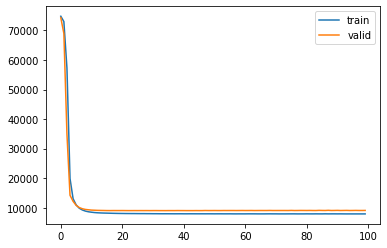

In [27]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()

In [28]:
y_pred = model.predict(ds_test)

metrics_and_model = get_results(y_test, y_pred[:, 0], 'dnn_regressor', model)
results = results.append(metrics_and_model, ignore_index=True)

In [29]:
results.set_index('model_name').drop('model', axis=1).style.format(style_format)

,explained_variance,mae,mape,r2
model_name,,,,
benchmark_median_price,0%,16412,26%,-0%
benchmark_median_price_per_post_code,25%,13439,22%,24%
linear_model,60%,9780,14%,60%
dnn_regressor,63%,9081,13%,62%


### Wide And Deep Model

In [30]:
features_input = {'new_building': tf.keras.layers.Input(name='new_building', shape=(), dtype='float32'),
                  'promoted': tf.keras.layers.Input(name='promoted', shape=(), dtype='float32'),
                  'area':  tf.keras.layers.Input(name='area', shape=(), dtype='float32'),
                  'type': tf.keras.layers.Input(name='type', shape=(), dtype='string'),
                  'post_code': tf.keras.layers.Input(name='post_code', shape=(), dtype='string')}

deep_model = tf.keras.layers.DenseFeatures(deep, name='deep_features')(features_input)
deep_model = tf.keras.layers.Dense(1024, activation='relu', name='deep_dense_1024')(deep_model)
deep_model = tf.keras.layers.Dense(512, activation='relu', name='deep_dense_512')(deep_model)
deep_model = tf.keras.layers.Dense(256, activation='relu', name='deep_dense_256')(deep_model)
deep_model = tf.keras.layers.Dense(128, activation='relu', name='deep_dense_128')(deep_model)

wide_model = tf.keras.layers.DenseFeatures(wide, name='wide_features')(features_input)

wide_and_deep = tf.keras.layers.concatenate([deep_model, wide_model], name='wide_and_deep_features')

res = tf.keras.layers.Dense(1, activation='relu', name='pred')(wide_and_deep)

model = tf.keras.Model(features_input, res)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

In [31]:
%%time
hist = model.fit(ds_train,
                 validation_data=ds_test,
                 epochs=100,
                 verbose=0)

CPU times: user 3min 20s, sys: 13.5 s, total: 3min 34s
Wall time: 35.2 s


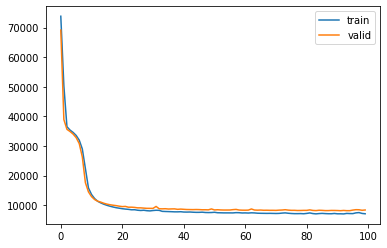

In [32]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()

In [33]:
y_pred = model.predict(ds_test)

metrics_and_model = get_results(y_test, y_pred[:, 0], 'wide_and_deep_regressor', model)
results = results.append(metrics_and_model, ignore_index=True)

In [34]:
results.set_index('model_name').drop('model', axis=1).style.format(style_format)

,explained_variance,mae,mape,r2
model_name,,,,
benchmark_median_price,0%,16412,26%,-0%
benchmark_median_price_per_post_code,25%,13439,22%,24%
linear_model,60%,9780,14%,60%
dnn_regressor,63%,9081,13%,62%
wide_and_deep_regressor,67%,8374,12%,67%


### Combined Model

In [35]:
stop_words = ['av', 'bak', 'blant', 'etter', 'for', 'fra',
              'gjennom', 'hos', 'i', 'ifølge', 'innen',
              'innenfor', 'med', 'mellom', 'mot', 'om',
              'omkring', 'ovenfor', 'på', 'rundt', 'til',
              'under', 'på grunn av', 'henhold','ved',
              'og', 'over', 'pa', 'etg', 'inkl', 'ingen',
              'kvm', 'en', 'et', 'alt', 'ca', 'm2']

In [36]:
count_vect = feature_extraction.text.CountVectorizer(strip_accents='unicode',
                                                     stop_words=stop_words,
                                                     max_features=400,
                                                     min_df=0.05,
                                                     max_df=0.95
                                                    )

In [37]:
count_vect.fit(data_train.short_desc)

/Users/ruslan.kozhuharov/venvs/tf/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['grunn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.95, max_features=400, min_df=0.05,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['av', 'bak', 'blant', 'etter', 'for', 'fra',
                            'gjennom', 'hos', 'i', 'ifølge', 'innen',
                            'innenfor', 'med', 'mellom', 'mot', 'om', 'omkring',
                            'ovenfor', 'på', 'rundt', 'til', 'under',
                            'på grunn av', 'henhold', 'ved', 'og', 'over', 'pa',
                            'etg', 'inkl', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [38]:
vocab = pd.Series(count_vect.vocabulary_).sort_values().to_frame().transpose().columns.to_list()

In [39]:
print(vocab)

['attraktiv', 'bad', 'balkong', 'barnevennlig', 'beliggenhet', 'felles', 'flott', 'fyring', 'garasje', 'garasjeplass', 'gjennomgaende', 'god', 'grunerløkka', 'hage', 'heis', 'hjørneleilighet', 'høy', 'kjøkken', 'klassisk', 'lave', 'leilighet', 'lekker', 'lys', 'meget', 'moderne', 'mulighet', 'peis', 'pen', 'plan', 'planløsning', 'rolig', 'roms', 'romslig', 'selveier', 'sentralt', 'solrik', 'standard', 'stor', 'takhøyde', 'takterrasse', 'terrasse', 'to', 'toppleilighet', 'utsikt', 'varmtvann', 'vestvendt']


In [40]:
vocab_size = len(count_vect.vocabulary_)

In [41]:
text_train = count_vect.transform(data_train.short_desc)
text_test = count_vect.transform(data_test.short_desc)

In [42]:
text_train

<7687x46 sparse matrix of type '<class 'numpy.int64'>'
	with 42600 stored elements in Compressed Sparse Row format>

In [43]:
features_input = {'new_building': tf.keras.layers.Input(name='new_building', shape=(), dtype='float32'),
                  'promoted': tf.keras.layers.Input(name='promoted', shape=(), dtype='float32'),
                  'area':  tf.keras.layers.Input(name='area', shape=(), dtype='float32'),
                  'type': tf.keras.layers.Input(name='type', shape=(), dtype='string'),
                  'post_code': tf.keras.layers.Input(name='post_code', shape=(), dtype='string'),
                  'text_vect': tf.keras.layers.Input(name='text_vect', shape=(vocab_size), dtype='float32')}

text_vect = tf.feature_column.numeric_column(key='text_vect', shape=(vocab_size,))

deep_model = tf.keras.layers.DenseFeatures(features + [text_vect], name='deep_features')(features_input)
deep_model = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(deep_model)
deep_model = tf.keras.layers.Dense(128, activation='relu', name='dense_128')(deep_model)
deep_model = tf.keras.layers.Dense(32, activation='relu', name='dense_32')(deep_model)

In [44]:
res = tf.keras.layers.Dense(1, activation='relu', name='pred')(deep_model)

model = tf.keras.Model(features_input, res)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse', 'mae', 'mean_absolute_percentage_error'])

In [45]:
ds_text_train = tf.data.Dataset.from_tensor_slices(({'area': X_train.area,
                                                     'new_building': X_train.new_building,
                                                     'post_code': X_train.post_code,
                                                     'promoted': X_train.promoted,
                                                     'text_vect': text_train.todense(),
                                                     'type': X_train.type}, y_train))

ds_text_test = tf.data.Dataset.from_tensor_slices(({'area': X_test.area,
                                                    'new_building': X_test.new_building,
                                                    'post_code': X_test.post_code,
                                                    'promoted': X_test.promoted,
                                                    'text_vect': text_test.todense(),
                                                    'type': X_test.type}, y_test))

In [46]:
%%time
hist = model.fit(ds_text_train.batch(batch_size),
                 validation_data=ds_text_test.batch(batch_size),
                 epochs=100,
                 verbose=0)

CPU times: user 1min 7s, sys: 7.7 s, total: 1min 15s
Wall time: 18.9 s


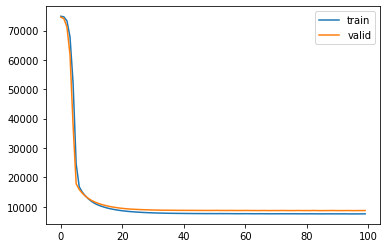

In [47]:
plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='valid')
plt.legend()
plt.show()

In [48]:
y_pred = model.predict(ds_text_test.batch(batch_size))

metrics_and_model = get_results(y_test, y_pred[:, 0], 'combined_model', model)
results = results.append(metrics_and_model, ignore_index=True)

In [49]:
results.set_index('model_name').drop('model', axis=1).style.format(style_format)

,explained_variance,mae,mape,r2
model_name,,,,
benchmark_median_price,0%,16412,26%,-0%
benchmark_median_price_per_post_code,25%,13439,22%,24%
linear_model,60%,9780,14%,60%
dnn_regressor,63%,9081,13%,62%
wide_and_deep_regressor,67%,8374,12%,67%
combined_model,66%,8699,13%,66%


### Error Visualization

In [69]:
best_model = results.loc[results.mae==results.mae.min(), 'model'].values[0]